## LSTM exercise for Time Series Data

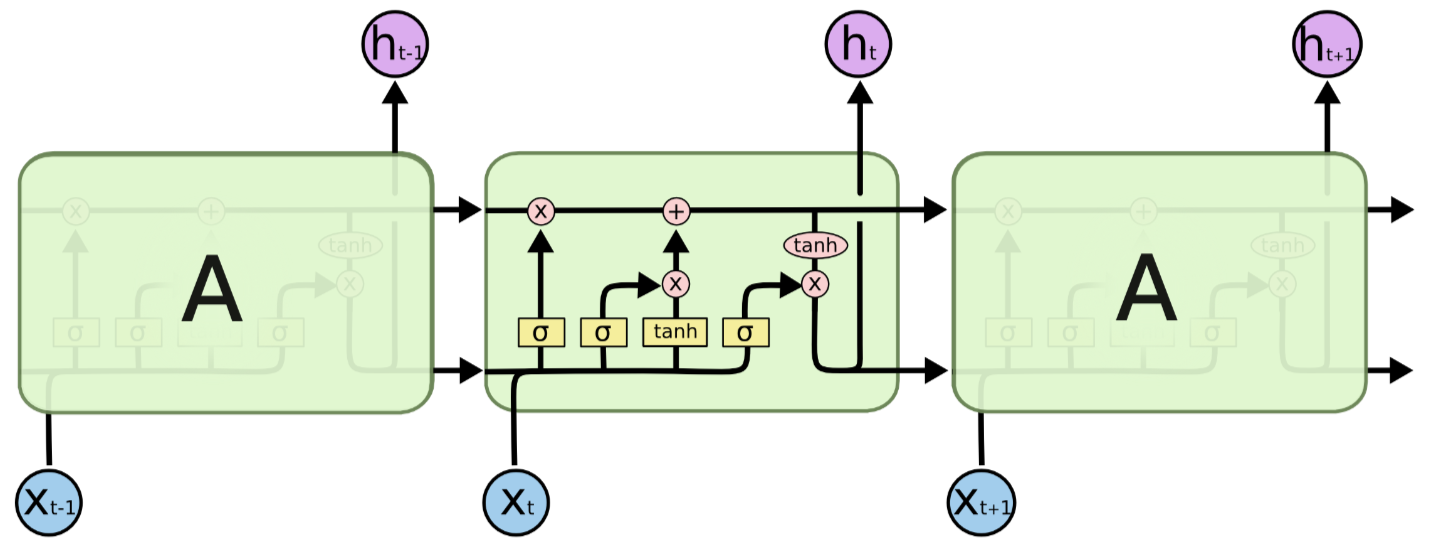

**Recurrent Neural Networks (RNNs)** suffer from the problem of vanishing gradients, which makes it difficult for them to learn long-range dependencies in sequential data. This issue arises because, during backpropagation through time (BPTT), the gradients diminish exponentially, preventing earlier time steps from having a meaningful influence on weight updates. Long Short-Term Memory (LSTM) networks solve this issue by introducing a special gating mechanism that enables them to retain important information over long sequences.

An LSTM cell consists of three key gates: the **forget gate**, the **input gate**, and the **output gate**. These gates regulate the flow of information through the **cell state** $C_t$, which acts as a memory unit. Given an input sequence $X = \{x_{t-1}, x_t, x_{t+1}, ...\}$, the LSTM updates its internal state as follows:

1. **Forget Gate**: Determines how much of the past cell state $C_{t-1}$ should be retained.
   $$
   f_t = \sigma(W_f [h_{t-1}, x_t] + b_f)
   $$
   where $W_f$ and $b_f$ are the weight matrix and bias, $h_{t-1}$ is the previous hidden state, $x_t$ is the current input, and $\sigma$ is the sigmoid activation function.

2. **Input Gate**: Decides how much new information should be added to the cell state.
   $$
   i_t = \sigma(W_i [h_{t-1}, x_t] + b_i)
   $$
   A candidate cell state is computed using a **tanh** activation:
   $$
   \tilde{C}_t = \tanh(W_C [h_{t-1}, x_t] + b_C)
   $$
   The actual update to the cell state is given by:
   $$
   C_t = f_t C_{t-1} + i_t \tilde{C}_t
   $$

3. **Output Gate**: Controls what part of the cell state contributes to the hidden state $h_t$, which is passed to the next time step.
   $$
   o_t = \sigma(W_o [h_{t-1}, x_t] + b_o)
   $$
   The final hidden state is:
   $$
   h_t = o_t \tanh(C_t)
   $$

The presence of the **cell state** $C_t$ ensures that gradients do not vanish or explode during backpropagation, allowing LSTMs to capture long-term dependencies. Unlike traditional RNNs, where the **hidden state** is directly updated at each time step, LSTMs use the gating mechanism to **selectively retain and update information**.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import random
import os

serie = pd.read_csv("gcd15_act3_serie3.csv")
serie.head()

,time,series
0,0,74.967140
1,1,65.737860
2,2,66.076880
3,3,64.630300
4,4,36.858467


## Train and test split

In [2]:
# we convert the dataframe columns into numpy arrays
time = serie["time"].to_numpy()  # time values
series = serie["series"].to_numpy()  # actual time series values
ratio = 0.75  # we will keep 75% for training, and 25% for testing
split_index = int(len(series) * ratio)  # split index

# Split into training and testing sets
time_train = time[:split_index]  # first 75% for training
time_test = time[split_index:]   # last 25% for testing
x_train = series[:split_index]   # training data values
x_test = series[split_index:]    # test data values

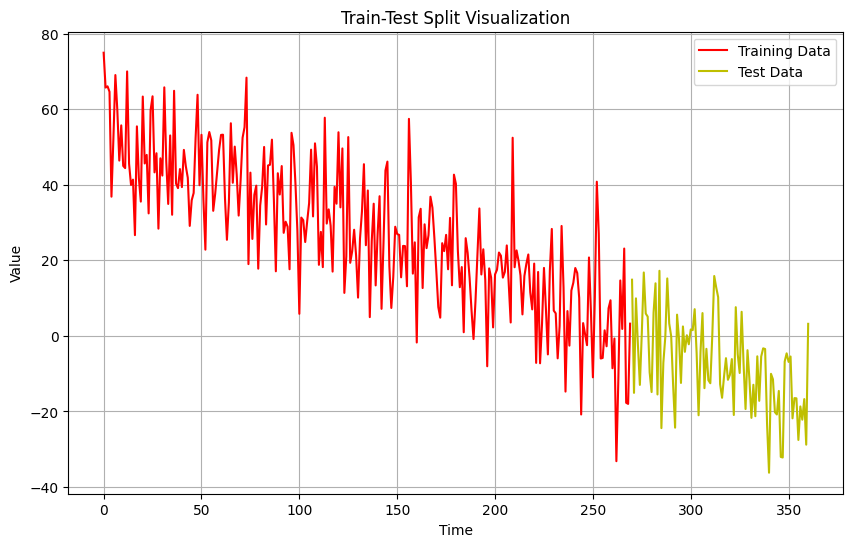

In [3]:
# we plot the training and test data to visualize the split
def plot_series(time, series, label, format="-"):
  plt.plot(time, series, format, label=label)
  plt.xlabel("Time")
  plt.ylabel("Value")
  plt.legend()
  plt.grid(True)
plt.figure(figsize=(10, 6))
plot_series(time_train, x_train, label="Training Data", format = "-r")
plot_series(time_test, x_test, label="Test Data", format = "-y")
plt.title("Train-Test Split Visualization")
plt.show()

## Parameters

In [4]:
# Assign parameters for LSTM model

# WINDOW SIZE:
# ------------------
# This defines the number of previous time steps the model will consider
# to make a prediction. Essentially, it's like a "memory" window where
# the model looks at the last 'window_size' values in order to predict
# the next one. # A small window size may not capture long-term trends,
# leading to poor predictions, while a very large window size might
# include unnecessary noise and increase computation time.

window_size = 20

# BATCH SIZE:
# ------------------
# This determines the number of samples processed before the model updates
# its internal weights. Instead of updating the model after every single
# data point (which would be slow), we update it after a batch of data.
# A larger batch size makes training more stable but requires more memory,
# while a smaller batch size can introduce more variability but updates the
# model more frequently.

batch_size = 32

# SHUFFLE BUFFER SIZE:
# ------------------
# This parameter determines how much randomness we introduce when creating
# training batches. Instead of processing data in strict chronological order
# (which could make the model overfit to the sequence), we shuffle the data
# to help generalize learning.

shuffle_buffer_size = 1000

In [5]:
# Function to create a windowed dataset for LSTM training (same function as used in class)
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    """
    Generates a tf dataset with sliding windows for LSTM training.
    Each window contains 'window_size' past observations as input and the next observation as the label.
    """
    dataset = tf.data.Dataset.from_tensor_slices(series) # convert the series data into a tf dataset object
    # Create sliding windows of size 'window_size + 1'
    # The +1 is because we need 'window_size' inputs and 1 target output, like an AR process
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1)) # flatten the dataset windows so that each window becomes a single tensor
    # Map each window to an (input, label) pair
    # The first 'window_size' values are inputs, the last value is the label
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    # Shuffle the dataset to introduce randomness and prevent overfitting to specific sequences
    dataset = dataset.shuffle(shuffle_buffer)
    # Batch the dataset to group 'batch_size' samples together for training efficiency
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>

## Model

In [6]:
# Define the LSTM model with bidirectional layers
model1 = tf.keras.models.Sequential([

    # Expand input dimensions to match LSTM expected input shape
    # LSTM layers expect input in the form (batch_size, time_steps, features)
    # Since we have a univariate time series (only one feature), we expand dims
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[window_size]),

    # First Bidirectional LSTM Layer
    # ----------------------------------------------------------------
    # Bidirectional: The model learns patterns moving forward and backward
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(
        units=32,             # number of LSTM neurons (memory units)
        return_sequences=True # allows the sequence to be processed further
    )),

    # Second Bidirectional LSTM Layer
    # ----------------------------------------------------------------
    # Another LSTM layer, this time without return_sequences (since it's the last LSTM layer)
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(
        units=32              # again, 32 LSTM neurons for consistency
    )),

    # Dense Output Layer
    # ----------------------------------------------------------------
    # Fully connected layer that outputs a single value (time series prediction)
    tf.keras.layers.Dense(
        units=1               # only 1 neuron since we predict a single value per time step
    ),

    # Scaling Output Layer
    # ----------------------------------------------------------------
    # Same like the class example, we scale predictions by multiplying by 100
    tf.keras.layers.Lambda(lambda x: x * 100.0)
])

model1.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/lambda_layer.py:65: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lambda (Lambda)                      │ (None, 20, 1)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 20, 64)              │           8,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 64)                  │          24,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              65 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lambda_1 (Lambda)                    │ (None, 1)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 33,601 (131.25 KB)

 Trainable params: 33,601 (131.25 KB)

 Non-trainable params: 0 (0.00 B)

## Learning Rate Tuning

In [7]:
# Set the learning rate scheduler
# The learning rate increases exponentially over epochs to find the optimal value (we do not keep it constant)
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20)
)

optimizer = tf.keras.optimizers.SGD(momentum=0.9) # SGD is used for optimizing, and momentum helps accelerate learning
model1.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer) # Compile the model with the Huber loss function
history = model1.fit(dataset, epochs=100, callbacks=[lr_schedule]) # Train the model for 100 epochs with the learning rate scheduler

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - loss: 23.9939 - learning_rate: 1.0000e-08
Epoch 2/100


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 22.8209 - learning_rate: 1.1220e-08
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 20.8306 - learning_rate: 1.2589e-08
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 20.0910 - learning_rate: 1.4125e-08
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 17.8381 - learning_rate: 1.5849e-08
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 14.2754 - learning_rate: 1.7783e-08
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 11.4940 - learning_rate: 1.9953e-08
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 10.5740 - learning_rate: 2.2387e-08
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 10.5911 - learning_rate: 2.5119e-08
Epoch 10/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 10.8065 - learning_rate: 2.8184e-08
Epoch 11/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 11.0379 - learning_rate: 3.1623e-08
Epoch 12/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 11.1078 - l

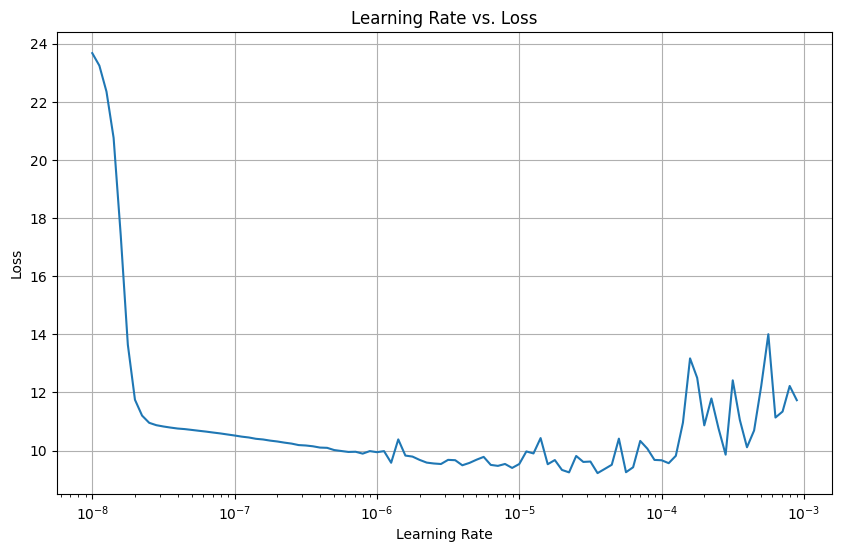

In [8]:
# Plot learning rate vs. loss
lrs = 1e-8 * (10 ** (np.arange(100) / 20))  # generate an array of learning rates
plt.figure(figsize=(10, 6))
plt.semilogx(lrs, history.history["loss"])  # logscale for learning rate
plt.xlabel("Learning Rate")
plt.ylabel("Loss")
plt.title("Learning Rate vs. Loss")
plt.grid(True)
plt.show()

# The loss decreases initially as the learning rate increases
# Around 10⁻⁵, the loss is at its lowest, indicating a good learning rate
# Beyond 10⁻⁴, the loss starts fluctuating, meaning the model is destabilizing

## Refitting the model

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 248ms/step - loss: 9.4390 - mae: 9.9334 - mse: 154.2987 - val_loss: 18.5842 - val_mae: 19.0806 - val_mse: 510.7485
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 9.5092 - mae: 10.0014 - mse: 163.9661 - val_loss: 18.3974 - val_mae: 18.8876 - val_mse: 504.1835
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 9.5953 - mae: 10.0858 - mse: 162.4145 - val_loss: 18.1416 - val_mae: 18.6345 - val_mse: 495.2568
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 9.2192 - mae: 9.7077 - mse: 154.5281 - val_loss: 17.9420 - val_mae: 18.4392 - val_mse: 488.3459
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 9.0309 - mae: 9.5183 - mse: 148.9371 - val_loss: 17.7955 - val_mae: 18.2904 - val_mse: 483.2794
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 9.8084 - mae: 10.3003 - mse: 167.9318 - val_loss: 17.7382 - val_mae: 18.2301 - val_mse: 481.5128
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 9.4334 - mae: 

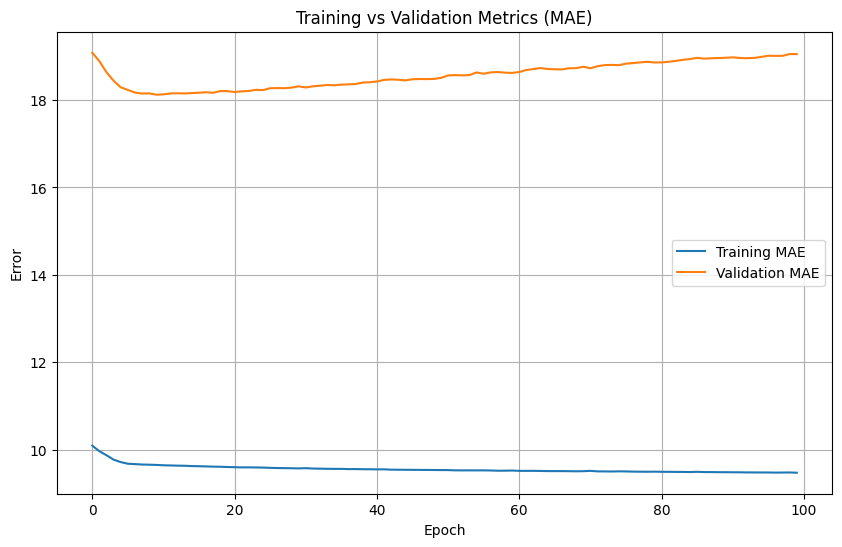

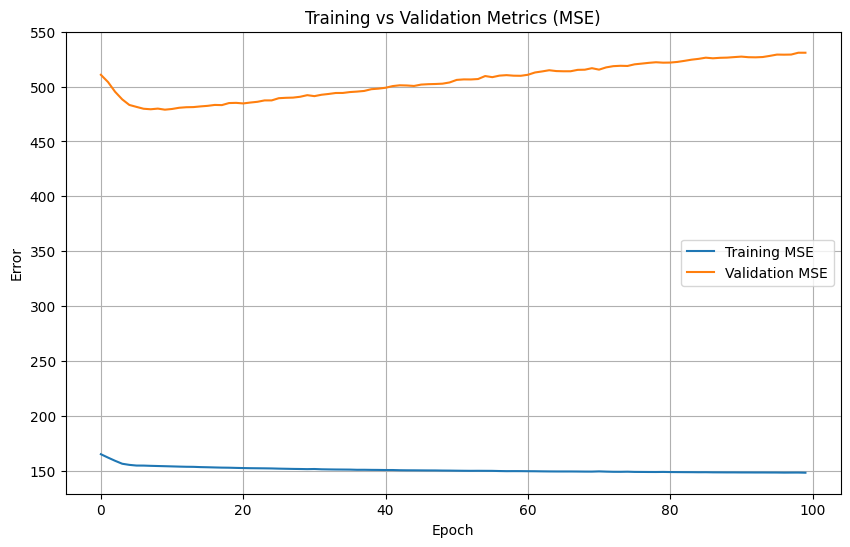

In [9]:
learning_rate = 2e-6 # set the optimal learning rate found from the tuning process
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9) # initialize the optimizer
model1.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer, metrics=["mae", "mse"]) # compile the model with Huber loss and track MSE and MAE
history = model1.fit(dataset, epochs=100, validation_data=windowed_dataset(x_test, window_size, batch_size, shuffle_buffer_size)) # train the model and store history

# Plot training and validation metrics
plt.figure(figsize=(10, 6))
plt.plot(history.history["mae"], label="Training MAE")
plt.plot(history.history["val_mae"], label="Validation MAE")
plt.xlabel("Epoch")
plt.ylabel("Error")
plt.title("Training vs Validation Metrics (MAE)")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(history.history["mse"], label="Training MSE")
plt.plot(history.history["val_mse"], label="Validation MSE")
plt.xlabel("Epoch")
plt.ylabel("Error")
plt.title("Training vs Validation Metrics (MSE)")
plt.legend()
plt.grid(True)
plt.show()

In [10]:
# Performance metrics on test data
eval_results = model1.evaluate(windowed_dataset(x_test, window_size, batch_size, shuffle_buffer_size))
print(f"Final Evaluation - Loss: {eval_results[0]}, MAE: {eval_results[1]}, MSE: {eval_results[2]}")

# El método evaluate() calcula una medida global del rendimiento del modelo en todo el conjunto de datos de prueba

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 17.9607 - mae: 18.4534 - mse: 499.8815
Final Evaluation - Loss: 18.555631637573242, MAE: 19.04924964904785, MSE: 530.87158203125


## Softsign and no bidirectional

In [11]:
# Define the LSTM model with softsign activation and no bidirectional layers
model2 = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[window_size]), # expand input dimensions to fit LSTM layer
    tf.keras.layers.LSTM(32, return_sequences=True, activation="softsign"),                  # first LSTM layer with softsign activation (removing bidirectional)
    tf.keras.layers.LSTM(32, activation="softsign"),                                         # second LSTM layer with softsign activation
    tf.keras.layers.Dense(1),                                                                # single output
    tf.keras.layers.Lambda(lambda x: x * 100.0)                                              # scaling
])

model2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lambda_2 (Lambda)                    │ (None, 20, 1)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 20, 32)              │           4,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 32)                  │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              33 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lambda_3 (Lambda)                    │ (None, 1)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 12,705 (49.63 KB)

 Trainable params: 12,705 (49.63 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 159ms/step - loss: 18.1536 - mae: 18.6455 - mse: 512.1623 - val_loss: 8.5988 - val_mae: 9.0875 - val_mse: 127.7483
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 12.6495 - mae: 13.1379 - mse: 270.2885 - val_loss: 8.7360 - val_mae: 9.2266 - val_mse: 132.1442
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 12.4301 - mae: 12.9254 - mse: 257.7443 - val_loss: 8.8137 - val_mae: 9.3105 - val_mse: 134.8060
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 11.2206 - mae: 11.7096 - mse: 205.0450 - val_loss: 8.8522 - val_mae: 9.3496 - val_mse: 136.1828
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 11.5510 - mae: 12.0431 - mse: 222.3379 - val_loss: 8.8683 - val_mae: 9.3657 - val_mse: 136.8168
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step - loss: 11.5676 - mae: 12.0592 - mse: 221.9805 - val_loss: 8.8376 - val_mae: 9.3347 - val_mse: 135.8246
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 11.3591 - mae: 1

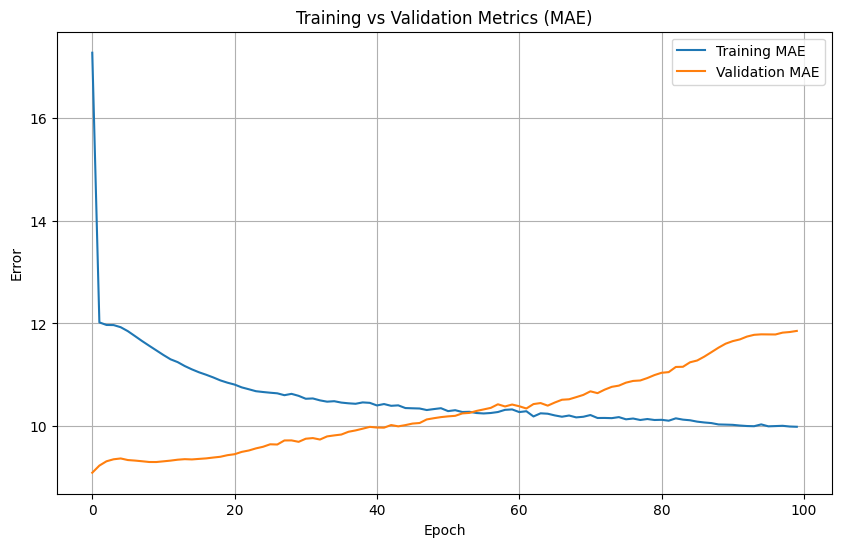

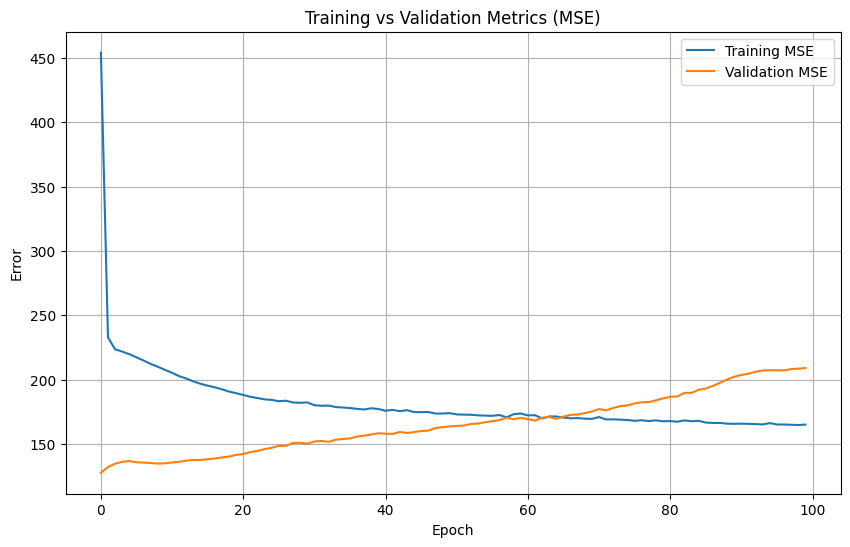

In [12]:
learning_rate = 2e-6 # set the optimal learning rate found from the tuning process
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9) # initialize the optimizer
model2.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer, metrics=["mae", "mse"]) # compile the model with Huber loss and track MSE and MAE
history = model2.fit(dataset, epochs=100, validation_data=windowed_dataset(x_test, window_size, batch_size, shuffle_buffer_size)) # train the model and store history

# Plot training and validation metrics
plt.figure(figsize=(10, 6))
plt.plot(history.history["mae"], label="Training MAE")
plt.plot(history.history["val_mae"], label="Validation MAE")
plt.xlabel("Epoch")
plt.ylabel("Error")
plt.title("Training vs Validation Metrics (MAE)")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(history.history["mse"], label="Training MSE")
plt.plot(history.history["val_mse"], label="Validation MSE")
plt.xlabel("Epoch")
plt.ylabel("Error")
plt.title("Training vs Validation Metrics (MSE)")
plt.legend()
plt.grid(True)
plt.show()

In [13]:
# Performance metrics on test data
eval_results = model2.evaluate(windowed_dataset(x_test, window_size, batch_size, shuffle_buffer_size))
print(f"Final Evaluation - Loss: {eval_results[0]}, MAE: {eval_results[1]}, MSE: {eval_results[2]}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 11.8500 - mae: 12.3424 - mse: 224.7361
Final Evaluation - Loss: 11.360346794128418, MAE: 11.853389739990234, MSE: 209.0989990234375


## Softsign and bidirectional

In [14]:
# Define the LSTM model with softsign activation and bidirectional layers
model3 = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[window_size]),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True, activation="softsign")),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, activation="softsign")),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])

model3.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lambda_4 (Lambda)                    │ (None, 20, 1)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_2 (Bidirectional)      │ (None, 20, 64)              │           8,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_3 (Bidirectional)      │ (None, 64)                  │          24,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              65 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lambda_5 (Lambda)                    │ (None, 1)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 33,601 (131.25 KB)

 Trainable params: 33,601 (131.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 9s 182ms/step - loss: 12.7469 - mae: 13.2399 - mse: 275.4492 - val_loss: 10.0387 - val_mae: 10.5313 - val_mse: 170.9227
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 12.2923 - mae: 12.7806 - mse: 247.8147 - val_loss: 10.0039 - val_mae: 10.4992 - val_mse: 169.9058
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 10.9872 - mae: 11.4821 - mse: 205.0018 - val_loss: 9.9874 - val_mae: 10.4826 - val_mse: 169.4726
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 11.1786 - mae: 11.6753 - mse: 216.1950 - val_loss: 9.9765 - val_mae: 10.4721 - val_mse: 169.2204
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 11.4816 - mae: 11.9781 - mse: 223.1273 - val_loss: 9.9573 - val_mae: 10.4533 - val_mse: 168.7482
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 10.9666 - mae: 11.4585 - mse: 210.3626 - val_loss: 9.9355 - val_mae: 10.4286 - val_mse: 168.1854
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 11.3311 -

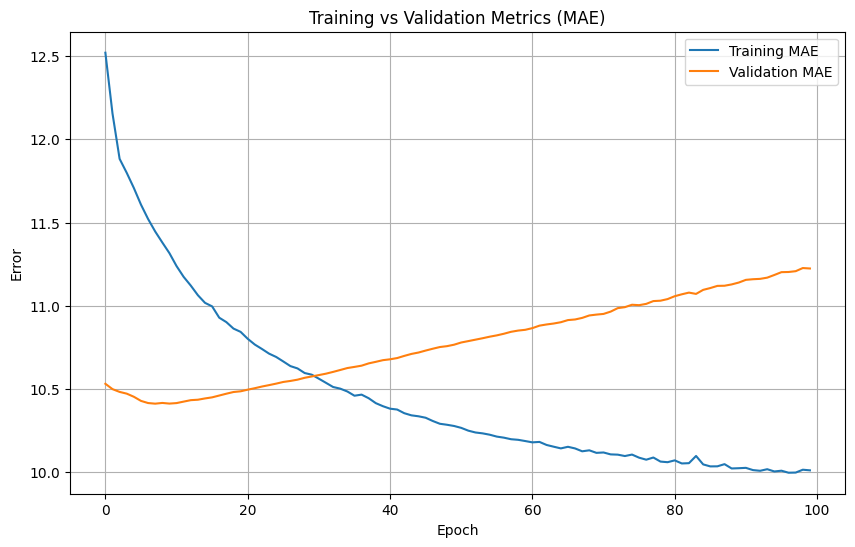

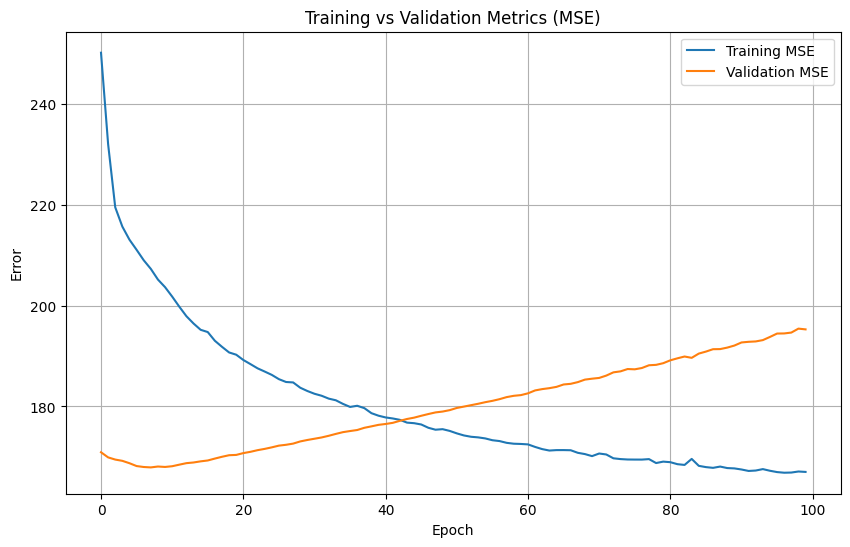

In [15]:
learning_rate = 2e-6 # set the optimal learning rate found from the tuning process
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9) # initialize the optimizer
model3.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer, metrics=["mae", "mse"]) # compile the model with Huber loss and track MSE and MAE
history = model3.fit(dataset, epochs=100, validation_data=windowed_dataset(x_test, window_size, batch_size, shuffle_buffer_size)) # train the model and store history

# Plot training and validation metrics
plt.figure(figsize=(10, 6))
plt.plot(history.history["mae"], label="Training MAE")
plt.plot(history.history["val_mae"], label="Validation MAE")
plt.xlabel("Epoch")
plt.ylabel("Error")
plt.title("Training vs Validation Metrics (MAE)")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(history.history["mse"], label="Training MSE")
plt.plot(history.history["val_mse"], label="Validation MSE")
plt.xlabel("Epoch")
plt.ylabel("Error")
plt.title("Training vs Validation Metrics (MSE)")
plt.legend()
plt.grid(True)
plt.show()

In [16]:
# Performance metrics on test data
eval_results = model3.evaluate(windowed_dataset(x_test, window_size, batch_size, shuffle_buffer_size))
print(f"Final Evaluation - Loss: {eval_results[0]}, MAE: {eval_results[1]}, MSE: {eval_results[2]}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 11.2456 - mae: 11.7427 - mse: 214.8950
Final Evaluation - Loss: 10.72687816619873, MAE: 11.223888397216797, MSE: 195.29818725585938


## Original model, but no bidirectional

In [17]:
# original LSTM model without bidirectional layers
model4 = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[window_size]),
  tf.keras.layers.LSTM(32, return_sequences=True, activation="tanh"), # the default activation function is tanh for the main cell transformation
  tf.keras.layers.LSTM(32, activation="tanh"), # same here
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])

model4.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lambda_6 (Lambda)                    │ (None, 20, 1)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_6 (LSTM)                        │ (None, 20, 32)              │           4,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_7 (LSTM)                        │ (None, 32)                  │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              33 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lambda_7 (Lambda)                    │ (None, 1)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 12,705 (49.63 KB)

 Trainable params: 12,705 (49.63 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 94ms/step - loss: 15.2049 - mae: 15.6960 - mse: 377.7745 - val_loss: 11.7608 - val_mae: 12.2481 - val_mse: 220.7763
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 14.0353 - mae: 14.5277 - mse: 315.7393 - val_loss: 11.4170 - val_mae: 11.9034 - val_mse: 209.6227
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 12.2630 - mae: 12.7544 - mse: 244.1201 - val_loss: 11.3020 - val_mae: 11.7963 - val_mse: 206.1209
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 12.4661 - mae: 12.9581 - mse: 267.1684 - val_loss: 11.5399 - val_mae: 12.0252 - val_mse: 213.6937
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 11.4806 - mae: 11.9621 - mse: 228.6479 - val_loss: 11.8939 - val_mae: 12.3812 - val_mse: 224.8856
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 11.1019 - mae: 11.5930 - mse: 205.1558 - val_loss: 12.2085 - val_mae: 12.6987 - val_mse: 234.8499
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 10.674

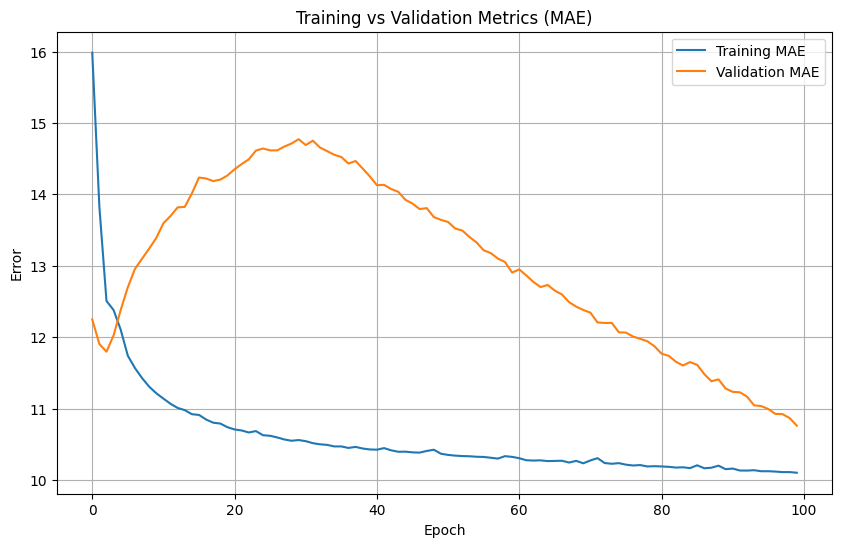

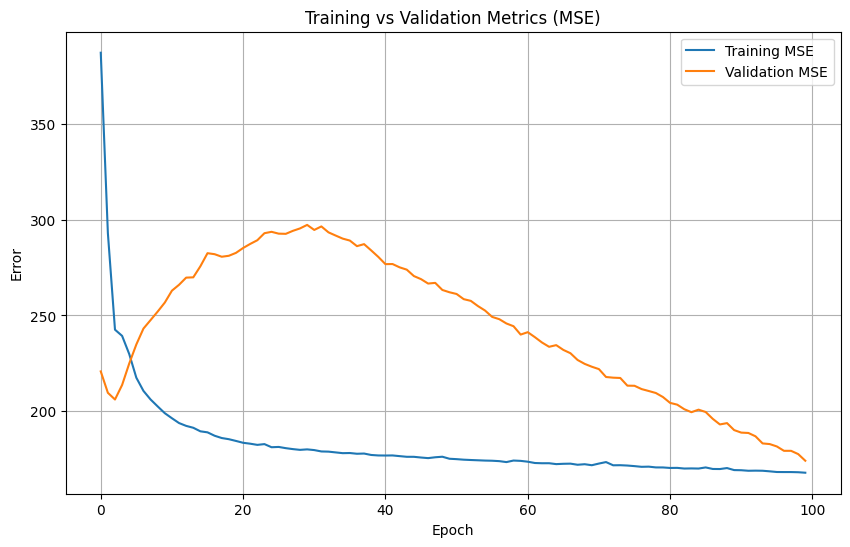

In [18]:
learning_rate = 2e-6 # set the optimal learning rate found from the tuning process
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9) # initialize the optimizer
model4.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer, metrics=["mae", "mse"]) # compile the model with Huber loss and track MSE and MAE
history = model4.fit(dataset, epochs=100, validation_data=windowed_dataset(x_test, window_size, batch_size, shuffle_buffer_size)) # train the model and store history

# Plot training and validation metrics
plt.figure(figsize=(10, 6))
plt.plot(history.history["mae"], label="Training MAE")
plt.plot(history.history["val_mae"], label="Validation MAE")
plt.xlabel("Epoch")
plt.ylabel("Error")
plt.title("Training vs Validation Metrics (MAE)")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(history.history["mse"], label="Training MSE")
plt.plot(history.history["val_mse"], label="Validation MSE")
plt.xlabel("Epoch")
plt.ylabel("Error")
plt.title("Training vs Validation Metrics (MSE)")
plt.legend()
plt.grid(True)
plt.show()

In [19]:
# Performance metrics on test data
eval_results = model4.evaluate(windowed_dataset(x_test, window_size, batch_size, shuffle_buffer_size))
print(f"Final Evaluation - Loss: {eval_results[0]}, MAE: {eval_results[1]}, MSE: {eval_results[2]}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 10.3823 - mae: 10.8705 - mse: 179.4880
Final Evaluation - Loss: 10.271820068359375, MAE: 10.761220932006836, MSE: 174.16619873046875


In [20]:
# Function to generate forecasts using the trained model
def model_forecast(model, series, window_size, batch_size):
  """
  Uses an input model to generate predictions on data windows.

  Args:
    model (TF Keras Model) - model that accepts data windows
    series (array of float) - contains the values of the time series
    window_size (int) - the number of time steps to include in the window
    batch_size (int) - the batch size

  Returns:
    forecast (numpy array) - array containing predictions
    """
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda w: w.batch(window_size))
  dataset = dataset.batch(batch_size).prefetch(1)
  forecast = model.predict(dataset)
  return forecast

In [21]:
# We choose the "best_model" as the one that has the lower loss
models = {
  "model1": model1,
  "model2": model2,
  "model3": model3,
  "model4": model4
}
test_losses = {}
for name, model in models.items():
  loss = model.evaluate(windowed_dataset(x_test, window_size, batch_size, shuffle_buffer_size), verbose=0)[0]  # evaluate returns a list; the first element [0] is the loss
  test_losses[name] = loss

best_model_name = min(test_losses, key=test_losses.get)
best_loss = test_losses[best_model_name]
best_model = models[best_model_name] # retrieve the actual model object from the dictionary
print(f"The best model is {best_model_name} with a test loss of {round(best_loss, 2)}.")

The best model is model4 with a test loss of 10.27.


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 185ms/step


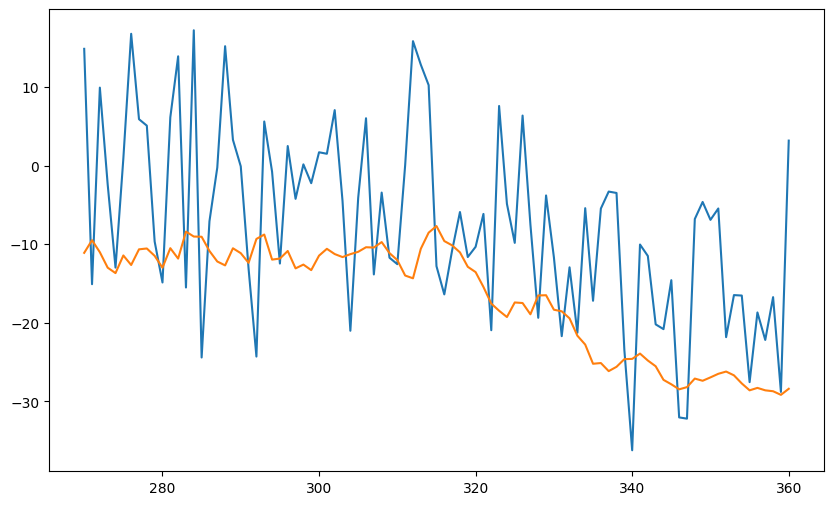

In [22]:
forecast_series = series[split_index-window_size:-1] # prepare the forecast series
forecast = model_forecast(best_model, forecast_series, window_size, batch_size) # we use the best trained model
results = forecast.squeeze() # drop single-dimensional axis

# Plot the actual vs predicted time series
def plot_series(time, series, format="-", start=0, end=None):
  """
  Visualizes time series data

  Args:
    time (array of int) - contains the time steps
    series (array of int or tuple) - contains the measurements for each time step
    format - line style when plotting the graph
    start - first time step to plot
    end - last time step to plot
  """
  plt.figure(figsize=(10, 6))
  if type(series) is tuple:
    for series_num in series:
        plt.plot(time[start:end], series_num[start:end], format)
  else:
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)
    plt.show()

plot_series(time_test, (x_test, results))

## No bidirectional, more epochs

Epoch 1/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 95ms/step - loss: 9.6739 - mae: 10.1610 - mse: 176.0641 - val_loss: 10.3024 - val_mae: 10.7903 - val_mse: 175.1626
Epoch 2/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 9.7733 - mae: 10.2645 - mse: 166.8923 - val_loss: 10.2192 - val_mae: 10.7087 - val_mse: 172.5467
Epoch 3/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 9.3258 - mae: 9.8079 - mse: 156.1984 - val_loss: 10.1158 - val_mae: 10.6028 - val_mse: 169.3206
Epoch 4/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 9.3334 - mae: 9.8177 - mse: 163.8836 - val_loss: 10.1244 - val_mae: 10.6116 - val_mse: 169.6421
Epoch 5/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 9.9735 - mae: 10.4671 - mse: 175.1980 - val_loss: 10.0583 - val_mae: 10.5436 - val_mse: 167.4377
Epoch 6/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 9.1521 - mae: 9.6399 - mse: 155.9179 - val_loss: 10.0530 - val_mae: 10.5380 - val_mse: 167.4634
Epoch 7/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step - loss: 9.3456 - mae: 9

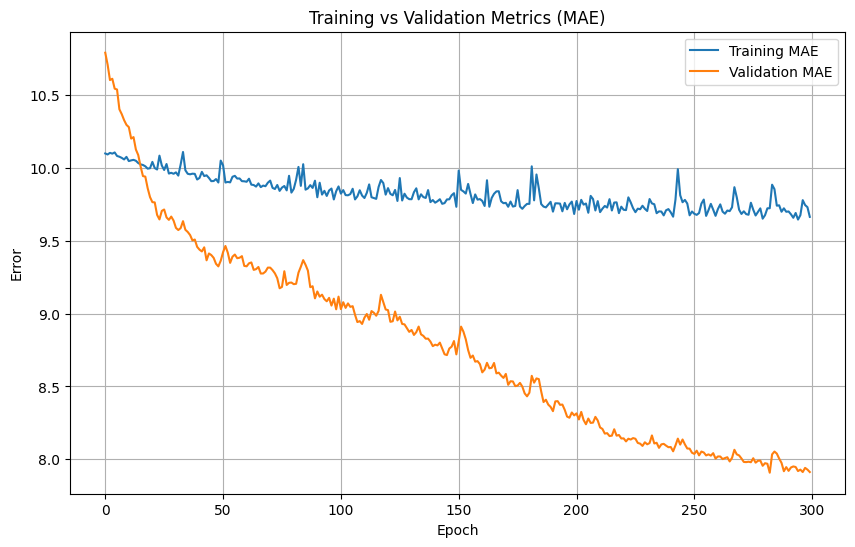

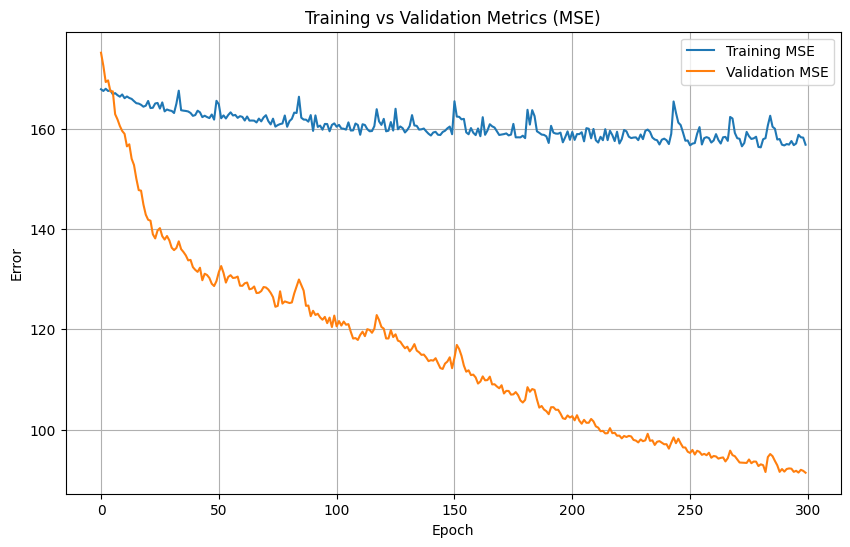

In [23]:
learning_rate = 2e-6 # set the optimal learning rate found from the tuning process
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9) # initialize the optimizer
model4.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer, metrics=["mae", "mse"]) # compile the model with Huber loss and track MSE and MAE
history = model4.fit(dataset, epochs=300, validation_data=windowed_dataset(x_test, window_size, batch_size, shuffle_buffer_size)) # train the model and store history

# Plot training and validation metrics
plt.figure(figsize=(10, 6))
plt.plot(history.history["mae"], label="Training MAE")
plt.plot(history.history["val_mae"], label="Validation MAE")
plt.xlabel("Epoch")
plt.ylabel("Error")
plt.title("Training vs Validation Metrics (MAE)")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(history.history["mse"], label="Training MSE")
plt.plot(history.history["val_mse"], label="Validation MSE")
plt.xlabel("Epoch")
plt.ylabel("Error")
plt.title("Training vs Validation Metrics (MSE)")
plt.legend()
plt.grid(True)
plt.show()

In [24]:
# Performance metrics on test data
eval_results = model4.evaluate(windowed_dataset(x_test, window_size, batch_size, shuffle_buffer_size))
print(f"Final Evaluation - Loss: {eval_results[0]}, MAE: {eval_results[1]}, MSE: {eval_results[2]}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 7.6046 - mae: 8.1007 - mse: 94.7764
Final Evaluation - Loss: 7.417392730712891, MAE: 7.912400722503662, MSE: 91.39549255371094


## Original model, more epochs

Epoch 1/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 153ms/step - loss: 9.3063 - mae: 9.7899 - mse: 156.0259 - val_loss: 18.5459 - val_mae: 19.0392 - val_mse: 530.4949
Epoch 2/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 8.8636 - mae: 9.3491 - mse: 143.1096 - val_loss: 18.5687 - val_mae: 19.0627 - val_mse: 531.4399
Epoch 3/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 8.7999 - mae: 9.2900 - mse: 145.8190 - val_loss: 18.5672 - val_mae: 19.0610 - val_mse: 531.4032
Epoch 4/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 8.3285 - mae: 8.8168 - mse: 131.8809 - val_loss: 18.5641 - val_mae: 19.0576 - val_mse: 531.3685
Epoch 5/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 9.3942 - mae: 9.8799 - mse: 161.7253 - val_loss: 18.5719 - val_mae: 19.0656 - val_mse: 531.6793
Epoch 6/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 8.9104 - mae: 9.3924 - mse: 145.0775 - val_loss: 18.5825 - val_mae: 19.0763 - val_mse: 532.2604
Epoch 7/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 9.4034 - mae: 9.8

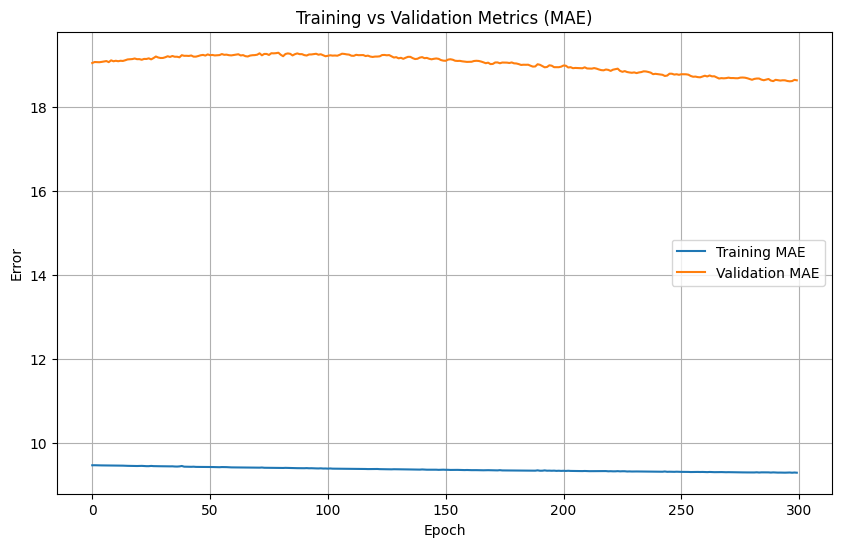

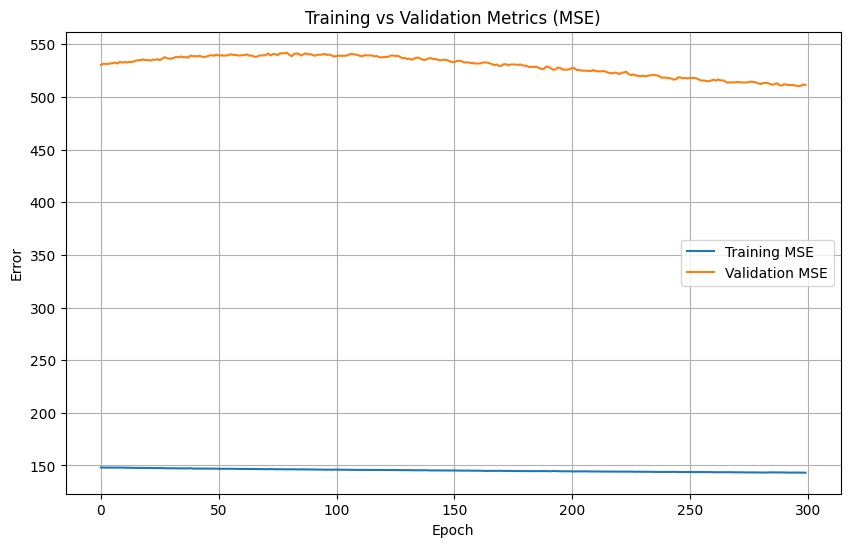

In [25]:
learning_rate = 2e-6 # set the optimal learning rate found from the tuning process
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9) # initialize the optimizer
model1.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer, metrics=["mae", "mse"]) # compile the model with Huber loss and track MSE and MAE
history = model1.fit(dataset, epochs=300, validation_data=windowed_dataset(x_test, window_size, batch_size, shuffle_buffer_size)) # train the model and store history

# Plot training and validation metrics
plt.figure(figsize=(10, 6))
plt.plot(history.history["mae"], label="Training MAE")
plt.plot(history.history["val_mae"], label="Validation MAE")
plt.xlabel("Epoch")
plt.ylabel("Error")
plt.title("Training vs Validation Metrics (MAE)")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(history.history["mse"], label="Training MSE")
plt.plot(history.history["val_mse"], label="Validation MSE")
plt.xlabel("Epoch")
plt.ylabel("Error")
plt.title("Training vs Validation Metrics (MSE)")
plt.legend()
plt.grid(True)
plt.show()

In [26]:
# Performance metrics on test data
eval_results = model1.evaluate(windowed_dataset(x_test, window_size, batch_size, shuffle_buffer_size))
print(f"Final Evaluation - Loss: {eval_results[0]}, MAE: {eval_results[1]}, MSE: {eval_results[2]}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 17.0796 - mae: 17.5545 - mse: 466.3456
Final Evaluation - Loss: 18.153066635131836, MAE: 18.628366470336914, MSE: 511.3737487792969


## Suboptimal Learning Rate

Let's try now a suboptimal learning rate for our original model.

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 152ms/step - loss: 130.8842 - mae: 131.3840 - mse: 35258.6953 - val_loss: 200.0473 - val_mae: 200.5473 - val_mse: 46067.8906
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 80.6105 - mae: 81.1105 - mse: 9038.9629 - val_loss: 160.0754 - val_mae: 160.5754 - val_mse: 47898.9453
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 49.8206 - mae: 50.3202 - mse: 3199.4219 - val_loss: 46.4029 - val_mae: 46.9029 - val_mse: 3566.2441
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 24.1488 - mae: 24.6479 - mse: 860.2110 - val_loss: 28.5518 - val_mae: 29.0405 - val_mse: 1137.6018
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 22.6088 - mae: 23.0995 - mse: 962.1953 - val_loss: 30.1353 - val_mae: 30.6271 - val_mse: 1545.9868
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 19.4789 - mae: 19.9742 - mse: 639.7231 - val_loss: 34.3454 - val_mae: 34.8454 - val_mse: 1911.4460
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms

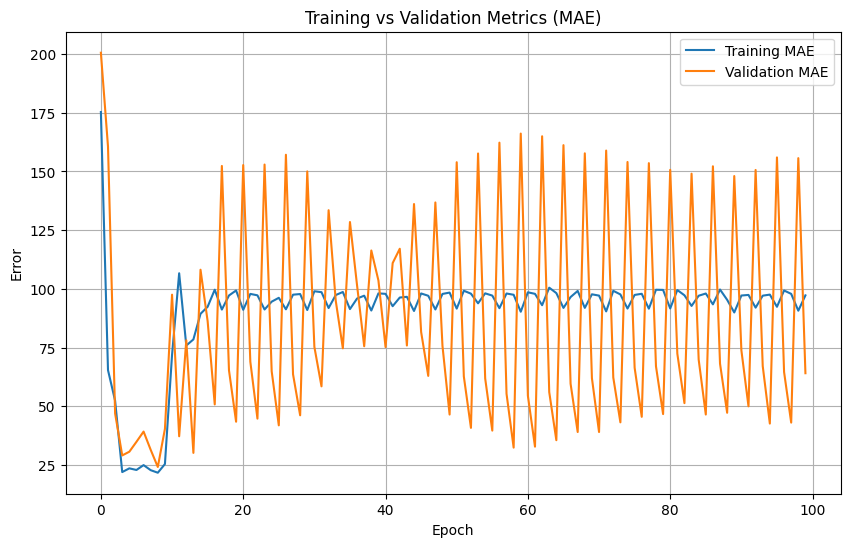

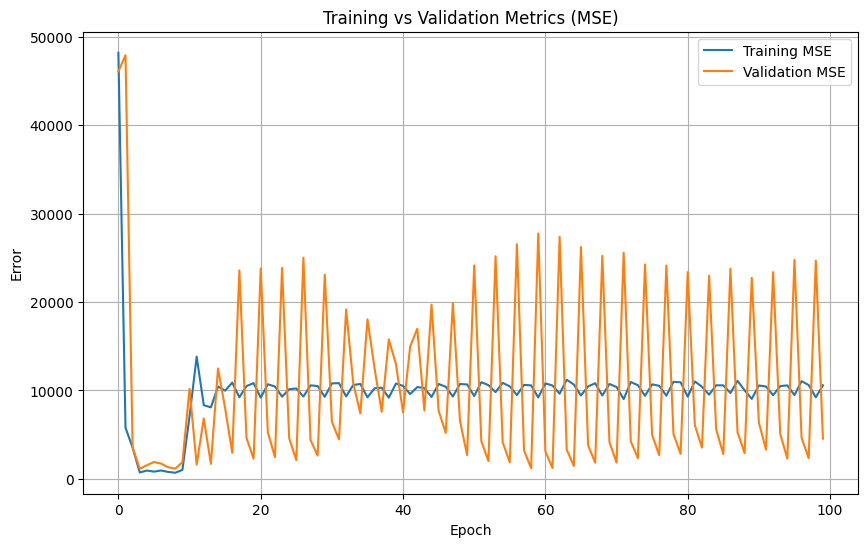

In [27]:
learning_rate = 1e-2 # too HIGH based on our learning rate search
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9) # initialize the optimizer
model1.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer, metrics=["mae", "mse"]) # compile the model with Huber loss and track MSE and MAE
history = model1.fit(dataset, epochs=100, validation_data=windowed_dataset(x_test, window_size, batch_size, shuffle_buffer_size)) # train the model and store history

# Plot training and validation metrics
plt.figure(figsize=(10, 6))
plt.plot(history.history["mae"], label="Training MAE")
plt.plot(history.history["val_mae"], label="Validation MAE")
plt.xlabel("Epoch")
plt.ylabel("Error")
plt.title("Training vs Validation Metrics (MAE)")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(history.history["mse"], label="Training MSE")
plt.plot(history.history["val_mse"], label="Validation MSE")
plt.xlabel("Epoch")
plt.ylabel("Error")
plt.title("Training vs Validation Metrics (MSE)")
plt.legend()
plt.grid(True)
plt.show()

In [28]:
# Performance metrics on test data
eval_results = model1.evaluate(windowed_dataset(x_test, window_size, batch_size, shuffle_buffer_size))
print(f"Final Evaluation - Loss: {eval_results[0]}, MAE: {eval_results[1]}, MSE: {eval_results[2]}") # terrible metrics

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 64.4849 - mae: 64.9849 - mse: 4693.2314
Final Evaluation - Loss: 63.55302429199219, MAE: 64.05302429199219, MSE: 4552.60009765625


Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - loss: 83.6194 - mae: 84.1194 - mse: 7406.4111 - val_loss: 63.5527 - val_mae: 64.0527 - val_mse: 4552.5625
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 85.4861 - mae: 85.9861 - mse: 7736.3843 - val_loss: 63.5522 - val_mae: 64.0521 - val_mse: 4552.4873
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - loss: 86.1367 - mae: 86.6367 - mse: 7850.8081 - val_loss: 63.5514 - val_mae: 64.0514 - val_mse: 4552.3970
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 83.1012 - mae: 83.6012 - mse: 7347.2261 - val_loss: 63.5507 - val_mae: 64.0507 - val_mse: 4552.2993
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 154ms/step - loss: 83.8026 - mae: 84.3026 - mse: 7445.0132 - val_loss: 63.5499 - val_mae: 64.0499 - val_mse: 4552.2002
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 83.3833 - mae: 83.8833 - mse: 7374.4595 - val_loss: 63.5491 - val_mae: 64.0491 - val_mse: 4552.0962
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step -

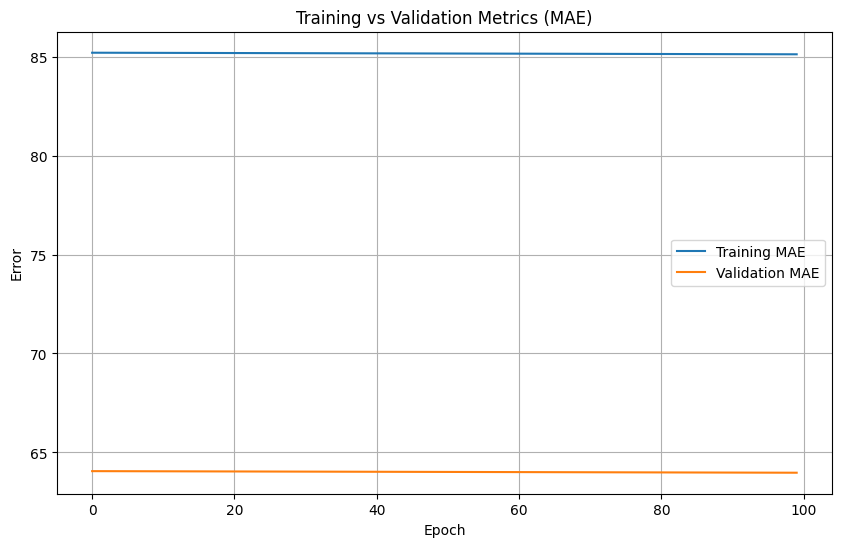

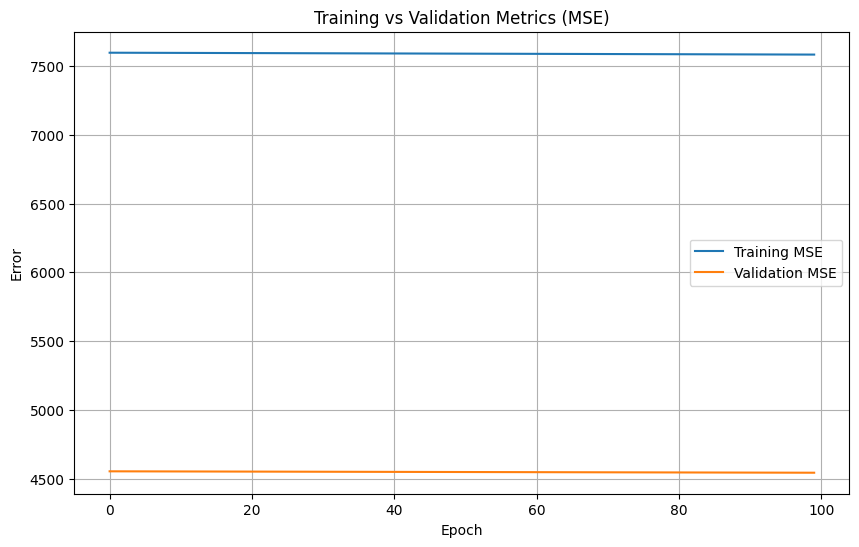

In [29]:
learning_rate = 1e-9 # too LOW based on our learning rate search
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9) # initialize the optimizer
model1.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer, metrics=["mae", "mse"]) # compile the model with Huber loss and track MSE and MAE
history = model1.fit(dataset, epochs=100, validation_data=windowed_dataset(x_test, window_size, batch_size, shuffle_buffer_size)) # train the model and store history

# Plot training and validation metrics
plt.figure(figsize=(10, 6))
plt.plot(history.history["mae"], label="Training MAE")
plt.plot(history.history["val_mae"], label="Validation MAE")
plt.xlabel("Epoch")
plt.ylabel("Error")
plt.title("Training vs Validation Metrics (MAE)")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(history.history["mse"], label="Training MSE")
plt.plot(history.history["val_mse"], label="Validation MSE")
plt.xlabel("Epoch")
plt.ylabel("Error")
plt.title("Training vs Validation Metrics (MSE)")
plt.legend()
plt.grid(True)
plt.show()

In [30]:
# Performance metrics on test data
eval_results = model1.evaluate(windowed_dataset(x_test, window_size, batch_size, shuffle_buffer_size))
print(f"Final Evaluation - Loss: {eval_results[0]}, MAE: {eval_results[1]}, MSE: {eval_results[2]}") # terrible metrics

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 63.7706 - mae: 64.2706 - mse: 4605.3418
Final Evaluation - Loss: 63.4728889465332, MAE: 63.9728889465332, MSE: 4542.34033203125


When using a **high learning rate (1e-2)**, the model exhibits extreme instability, as seen in the first plot. The training and validation MAE fluctuate erratically instead of gradually decreasing, indicating that the model struggles to converge. The high learning rate causes **overshooting**, where the **optimizer takes excessively large steps in weight updates**, preventing the model from settling into a stable minimum (this results in inconsistent performance, with spikes in error suggesting that the model fails to learn a coherent pattern from the data). On the other hand, with a **low learning rate (1e-9)**, the second plot shows that the **training** and **validation** MAE **remain constant throughout training**, indicating that the model is **not learning at all**. The **updates** to **model weights** are **so small** that they have no meaningful impact on performance, leading to a situation where the model is effectively stuck in its initial state. This results in poor predictive power, as the model does not adapt to the training data.

## Forward predictions

Initially, when using the trained model to iteratively predict new values up to time step 400, I encountered an issue where the predictions tended to **stabilize around a single value**, failing to maintain the variability and trend of the original time series. I think this problem arises because LSTMs, when used recursively with their own predictions as inputs, can become overly confident and **converge to a narrow range of values**. To address this, I introduced three key modifications: **temperature scaling**, **noise injection**, and **blending (alpha factor)**. **Temperature scaling** amplifies the predicted values, preventing the model from producing overly conservative estimates. **Noise injection** introduces small variations at each step, preventing the sequence from collapsing into a flat trend, which can occur when predictions depend solely on prior predictions. The **alpha blending factor** ensures that predictions remain anchored to the previous real values rather than completely diverging, striking a balance between learned patterns and randomness. These adjustments allowed me to generate predictions that more closely resemble the natural fluctuations of the observed data while still following its long-term trend. Without these modifications, the forecast would have lacked variability, making it unrealistic compared to the actual series.

/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step


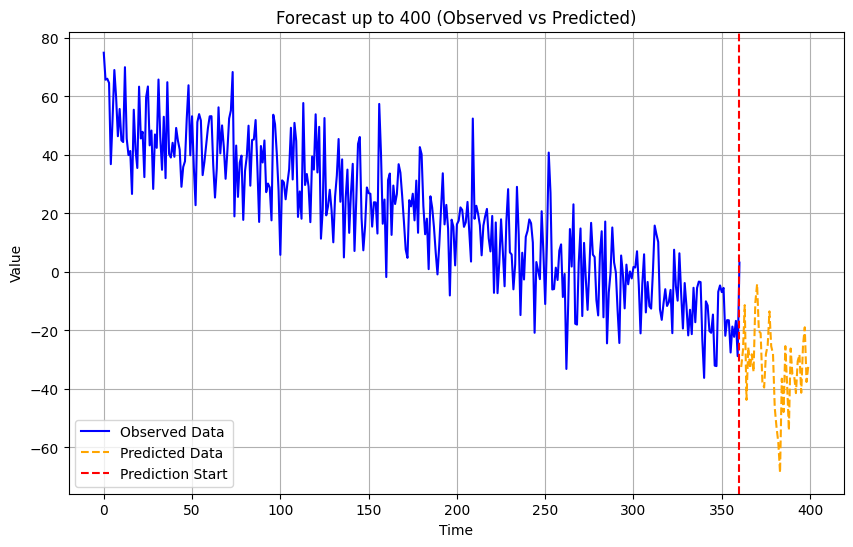

In [31]:
tf.config.run_functions_eagerly(True)

forecast = list(series)  # observed data
dummy_input = np.random.rand(1, window_size, 1).astype(np.float32)
_ = best_model.predict(dummy_input) # dummy pass to ensure the model is initialized

# Define noise and blending factor
alpha = 0.7  # how much we trust the prediction (closer to 1 = full prediction)
noise_factor = 0.5  # adds variability to prevent stabilization
temperature = 2.5  # increases uncertainty in predictions

while len(forecast) < 400:
  current_window = np.array(forecast[-window_size:], dtype=np.float32).reshape(1, window_size, 1)
  # Ensure it is explicitly a TensorFlow tensor
  input_window = tf.convert_to_tensor(current_window, dtype=tf.float32)
  # Make prediction
  try:
    pred = best_model.predict(input_window, verbose=0)
    next_value = pred[0, 0]
  except Exception as e:
    print(f"Prediction error: {e}")
    break

  next_value *= temperature # apply temperature scaling to add some randomness
  next_value += np.random.normal(scale=noise_factor * np.abs(next_value))   # inject small noise to prevent stabilization
  # Blend with previous real value to maintain trend
  adjusted_value = alpha * next_value + (1 - alpha) * forecast[-1]
  forecast.append(float(adjusted_value))

# PLOTTING
time_axis = np.arange(len(forecast))
start_pred = len(series) # index where predictions start
plt.figure(figsize=(10, 6))
plt.plot(time_axis[:start_pred], forecast[:start_pred], label="Observed Data", color="blue") # plot observed data (before predictions)
# Plot predicted data (after predictions start)
plt.plot(time_axis[start_pred:], forecast[start_pred:], label="Predicted Data", color="orange", linestyle="dashed")
# Mark the transition from observed to predicted
plt.axvline(x=start_pred - 1, color="red", linestyle="--", label="Prediction Start")
plt.xlabel("Time")
plt.ylabel("Value")
plt.title("Forecast up to 400 (Observed vs Predicted)")
plt.legend()
plt.grid(True)
plt.show()